Mounted at /content/drive


In [ ]:
print(const.AGEO_LENGTH_IN_CM)

147684.983


In [2]:
%%time
from tovlib import *
#solve_ivp: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp 
from scipy.integrate import solve_ivp


CPU times: user 13 µs, sys: 9 µs, total: 22 µs
Wall time: 24.8 µs


## Enthalpy formulation of TOV equation

In [10]:


class tov_h():

    def __init__(self, peos, eos_file, central_enth_arr, N_pts,h_end):
        self.physical_eos = peos
        self.eos_file = eos_file
        self.central_enth_arr = central_enth_arr
        self.N_pts = N_pts
        self.h_end = h_end

    def eos_from_h(self,h_in):
        
        ds=np.loadtxt(self.eos_file,comments='#',skiprows=5)
        #print(self.eos_file, len(ds)) 
        rho, edens, pres, gamma, enth = (ds[:,1],ds[:,2],ds[:,3],ds[:,4],ds[:,5])
        ## returning values in units G=c=M_sun=1 
        rho_out   = splev(h_in,splrep(enth,rho,k=3,s=0)) #* (const.CGS_G*const.AGEO_LENGTH_IN_CM**2/const.CGS_C**2)
        edens_out = splev(h_in,splrep(enth,edens,k=3,s=0)) * (const.CGS_G*const.AGEO_LENGTH_IN_CM/const.CGS_C**4) 
        gamma_out = splev(h_in,splrep(enth,gamma,k=3,s=0))
        pres_out  = splev(h_in,splrep(enth,pres,k=3,s=0)) * (const.CGS_G*const.AGEO_LENGTH_IN_CM/const.CGS_C**4)
        
        return edens_out, gamma_out, pres_out, rho_out
        
    def calc_tidal_deformability(self, C, Y,m):
        # """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and 
        # the Lindblom y-potential at the surface of a polytropic star"""

        # Eq.(C1,C2) of Lindblom & Indik 2014
        zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
        Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
        lambda_dimensional =   Lambda_dimensionless/const.CGS_G *(const.CGS_G*m*const.CGS_MSUN/const.CGS_C**2)**5
        return lambda_dimensional

    def tov(self, var,h):
        
        r, m, m_baryon, yp = var
        
        #if eos_file != None:
        #eden = self.physical_eos.edens_inv( P )
        #rho = self.physical_eos.rho( P )
        #eos_gamma = self.physical_eos.gamma_inv(P)
        
        #print(h)
        edens, eos_gamma, P, rho = self.eos_from_h(h)
        #print(edens, eos_gamma, P)
        
        #dPdh =  edens + P         
        #dPdr =  -(edens + P)*(m + 4.0*np.pi*r**3*P)
        #drdh =  dPdh/dPdr    #/(r*(r - 2.0*const.CGS_G*m/const.CGS_C**2))
        
        
        drdh = - r*(r-2*m)/(m+4*np.pi*r**3*P)
        dmdh = -4*np.pi*r**3*(r-2*m)/(m+4*np.pi*r**3*P)                  #drdh * 4.0*np.pi*r**2*edens
        dm_baryondh =   dmdh*(1-2*m/r)**(-0.5)

        #rho=eden*const.CGS_C**2
        dypdr = -yp**2/r -(r + 4*np.pi*r**3*(P-edens))*yp/(r*(r-2*m)) + (4*(m+4*np.pi*r**3*P)**2)/(r*(r-2*m)**2) + 6/(r-2*m) - 4*np.pi*(r**2)*(5*edens+9*P+(edens+P)**2/(P*eos_gamma))/(r-2*m)
        dypdh = dypdr * drdh
        
        return [drdh, dmdh, dm_baryondh,dypdh]

    def tovsolve(self, enth_c):
        
        N = self.N_pts
        h = np.linspace(enth_c,self.h_end,N)
        #print(h)
        #r = np.linspace(1.e0, 1.8e6, N)
        #r = np.logspace(0.0,6.3,N)
        #P = self.physical_eos.pressure( rhoc )
        #eden = self.physical_eos.edens_inv( P )
        #rho = self.physical_eos.rho( P )
        
        edens, gamma, pres, rho = self.eos_from_h(enth_c)
        #print(edens, gamma, pres, rho)
        #p = pres
        ###### Following Lindblom and IndiK ###
        #edens, gamma, pres, rho = self.eos_from_h(h[1])

        h_eps=h[0]-h[1]
        print(h_eps)
        
        
        """r1=np.sqrt(3./(2*np.pi*(edens+3*pres)))
        r3 = -(r1/(4*(edens+3*pres)))*(edens-3*pres-3*(edens+pres)**2/(5*pres*gamma))
        #print('r3',r3)
        r = r1*np.sqrt(h_eps) + r3*h_eps**1.5
        #print(r1*np.sqrt(h_eps),r3*h_eps**1.5)
        m3 = 4./3.*np.pi*r1**3*edens
        m5 = 4*np.pi*r1**3*(r3*edens/r1 - (edens+pres)**2/(5*pres*gamma))
        m = m3*h_eps**1.5 + m5*h_eps**2.5          #4*np.pi*r**3*edens                     #4.0*np.pi*r[0]**3*edens
        m_baryon = m*(1-2*m/r)**(-0.5)       #needs correct power series expression; perhaps ok for now     #4.0*np.pi*r[0]**3*rho*(1-2*const.CGS_G*m/(r[0]*const.CGS_C**2))**(-0.5)
        
        y2 = -(6/(7*(edens+3*pres))) * (edens/3 + 11*pres + (edens+pres)**2./(pres*gamma))
        yp=2.+y2*h_eps"""
        
        
        ### Naive initial consitions ####
        eps = 1.e-5
        r = eps
        m = 4*np.pi*r**3*edens
        m_baryon = m*(1-2*m/r)**(-0.5)
        yp = 2.
        
        print(r, m, m_baryon, yp)
        
        psol = odeint(self.tov, [r, m, m_baryon, yp], h, rtol=1.0e-4, atol=1.0e-4)
        #psol = solve_ivp(self.tov, [1.e0,5.8e6] ,[P, m, m_baryon, yp], method='RK45',t_eval=r )
        #print m, m_baryon, rhoc
        return psol[:,0], psol[:,1], psol[:,2], psol[:,3]
        #return psol.t, psol.y[0], psol.y[1], psol.y[2], psol.y[3] 

    def mass_radius(self):
        N = 10
        mcurve = np.zeros(N)
        rcurve = np.zeros(N)
        mbcurve = np.zeros(N)
        ypcurve = np.zeros(N)
        #rhocs = np.logspace(12.5, 20.0, N)
        
        #central_enth_arr = self.central_enth_arr #np.linspace(0.01,0.25,N)

        mass_max = 0.0
        j = 0
        for enth_c in self.central_enth_arr: #central_enth_arr:
            print(f'for central enthalpy = {enth_c}')
            rad, mass, mass_baryon, yp_lambda = self.tovsolve(enth_c)

            #rad  /= 1.0e5 #cm to km
            #mass /= const.CGS_MSUN
            #mass_baryon /= const.CGS_MSUN
            
            #print self.peos
            #print(rad)
            #print "Central Density=%f, Gravitational Mass=%f, Baryonic Mass=%f, Radius=%f"%(rhoc,mass.max(),mass_baryon.max(),rad.max())

            
            mstar = mass[-1]
            rstar = rad[-1]
            ypstar = yp_lambda[-1]
            mbaryonStar = mass_baryon[-1]
            
            """for i, p in enumerate(press):
                if p > 0.0:
                    mstar = mass[i]
                    rstar = rad[i]
                    mbaryonStar = mass_baryon[i]
                    ypstar = yp_lambda[i]"""
                    
            mcurve[j] = mstar
            rcurve[j] = rstar
            mbcurve[j] = mbaryonStar
            
            C=(const.CGS_G/const.CGS_C**2)*(mstar*const.CGS_MSUN)/(rstar*1.e5)
            ypcurve[j] = ypstar
            ypcurve[j] = self.calc_tidal_deformability(C,ypstar,mstar) 
    
            print(mstar,rstar)


            j += 1
            if mass_max < mstar:
                mass_max = mstar
            else:
                break

        return mcurve[:j], rcurve[:j], central_enth_arr[:j], mbcurve[:j], ypcurve[:j]


In [5]:
import numpy as np
import matplotlib.pyplot as plt


In [11]:
#key='BLH'; eosfile='./eos_tables/BLH_data.out'
key = 'ALF2'; eosfile='./eos_tables/ALF2_data.out'
#dense_eos = get_eos(key,eosfile)
#eos = glue_crust_and_core( SLyCrust, dense_eos )
N=1000
central_h_low=0.02; central_h_high = 0.25
central_enth_arr = np.linspace(central_h_low,central_h_high,N)
N_pts = 1000
h_end=0.0119
BLH=tov_h(peos=key,eos_file=eosfile,central_enth_arr=central_enth_arr,N_pts=N_pts,h_end=h_end)

h_in = np.linspace(h_end,central_h_high,100)
#print(h_in)
edens, eos_gamma, P, rho = BLH.eos_from_h(h_in)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

ax1.plot(h_in,edens)
#ax1.set_xlim([9.e11,1.e16]); 
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set(xlabel='h_in',ylabel='edens')

ax2.plot(h_in,eos_gamma)
ax2.set(xlabel='h_in',ylabel='eos_gamma')
#ax2.set_xlim([9.e11,1.e16]) 
ax2.set_xscale('log'); ax2.set_yscale('log')

ax3.plot(h_in,P)
ax3.set(xlabel='h_in',ylabel='Pressure')
ax3.grid(True)
#ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
ax3.set_xscale('log'); ax3.set_yscale('log')

ax4.plot(h_in, rho)
ax4.set_xscale('log'); ax4.set_yscale('log')
ax4.set(xlabel='h_in',ylabel='rho')
    
#plt.loglog(edens,h_in)
#plt.show()

plt.tight_layout()
plt.show()



OSError: ignored

0.0004885885885885788
1e-05 2.761896146824642e-22 2.761896146824642e-22 2.0


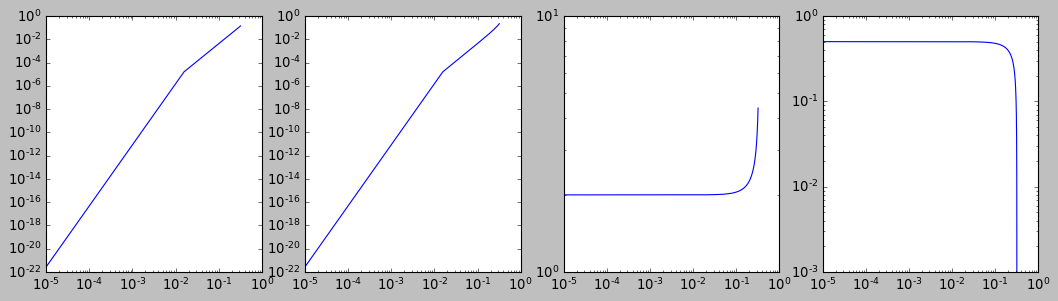

0.4474737812859623
0.1370358472731178


In [ ]:
enth_c = 0.5
rad, mass, mass_baryon, yp_lambda = BLH.tovsolve(enth_c)

h_arr = np.linspace(enth_c,1.e-3,N_pts)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
ax1.loglog(rad,mass)
ax2.loglog(rad,mass_baryon)
ax3.loglog(rad,yp_lambda)
ax4.loglog(rad,h_arr)
plt.show()

print(rad[-1]*1.4)
print(mass[-1])

In [ ]:
print(rad[-1]*const.AGEO_LENGTH_IN_CM/1.e5)
print(mass[-1],(mass[-1]*const.AGEO_LENGTH_IN_CM)*const.CGS_C**2/const.CGS_G/const.CGS_MSUN)

0.473862273425462
0.13862426932957087 0.13864515810302486


In [ ]:



#mass,radius,rhoc,mb,yp = BLH.mass_radius()
plt.plot(radius*const.AGEO_LENGTH_IN_CM/1.e5,(mass*const.AGEO_LENGTH_IN_CM)*const.CGS_C**2/const.CGS_G/const.CGS_MSUN,'r.')
plt.show()

NameError: name 'radius' is not defined

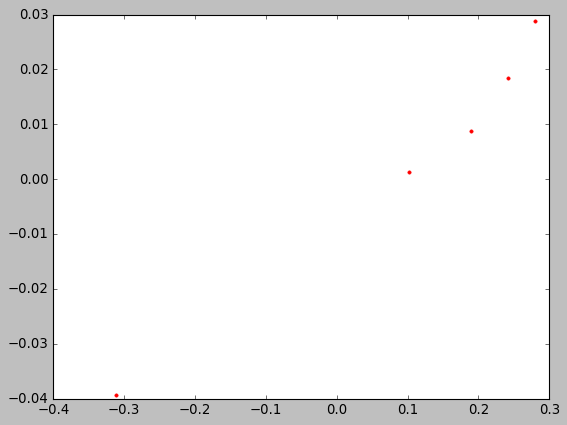

In [ ]:

plt.plot(radius*const.AGEO_LENGTH_IN_CM/1.e5,mass*(const.AGEO_LENGTH_IN_CM*const.CGS_C**2/const.CGS_G/const.CGS_MSUN),'r.')
plt.show()

In [ ]:
print(2.5*np.log((1.0e2*const.CGS_C**2+2.4e19)/(1.0e2*const.CGS_C**2)))

0.0006675009142067027


### Creating enthalpy table

7.77786843390644e-06


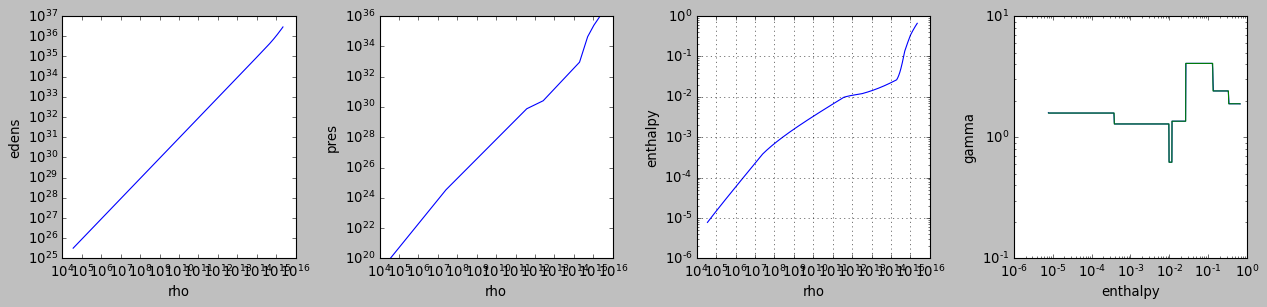

In [ ]:

fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

key='ALF2'
dense_eos = get_eos(key)
eos = glue_crust_and_core( SLyCrust, dense_eos )
pres_arr = np.logspace(20,36,1000)
edens_arr = np.array([eos.edens_inv(p) for p in pres_arr] )* const.CGS_C**2
rho_arr = [eos.rho(p) for p in pres_arr]
gamma = [eos.gamma_inv(p) for p in pres_arr]


dp_dedens_arr=np.gradient(pres_arr,edens_arr) #https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
gamma_arr=((edens_arr+pres_arr)/pres_arr) * dp_dedens_arr 
enth_arr=[]
enth_arr.append(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
print(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
for i,(rho,edens,pres) in enumerate(zip(rho_arr,edens_arr,pres_arr)):
    if i > 0:
        c = np.log(pres/pres_arr[i-1])/np.log(edens/edens_arr[i-1])
        enth_arr.append(enth_arr[i-1]+(c/(c-1))*np.log(edens_arr[i-1]/edens*(edens+pres)/(edens_arr[i-1]+pres_arr[i-1])))
        #print(enth_arr[i-1])

        
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

#print(enth_arr)
ax1.plot(rho_arr,edens_arr)
#ax1.set_xlim([9.e11,1.e16]); 
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set(xlabel='rho',ylabel='edens')
ax2.plot(rho_arr,pres_arr)
ax2.set(xlabel='rho',ylabel='pres')
#ax2.set_xlim([9.e11,1.e16]) 
ax2.set_xscale('log'); ax2.set_yscale('log')
ax3.plot(rho_arr,enth_arr)
ax3.set(xlabel='rho',ylabel='enthalpy')
ax3.grid(True)
#ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
ax3.set_xscale('log'); ax3.set_yscale('log')

ax4.plot(enth_arr,gamma_arr)
ax4.plot(enth_arr,gamma)
ax4.set_xscale('log'); ax4.set_yscale('log')
ax4.set(xlabel='enthalpy',ylabel='gamma')



#splrep(edens,enth,k=3,s=0)
    
plt.tight_layout()
plt.show()


index=np.array([int(i) for i in range(len(rho_arr))])   #  
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_arr, edens_arr, pres_arr, gamma_arr, enth_arr],header='\n#i rho edens pres gamma enthalpy',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

np.savetxt(f'./eos_tables/{key}_table.out',np.c_[index, np.array(rho_arr)/dens_conversion, np.array(edens_arr)/edens_conversion, pres_arr],header='\n#i rho edens pres',comments=f'#density, energy density and pressure in cgs units for eos={key}.\n')



6.379686072269269e-06
0.0006689770240705531
8.212708095846884e-06


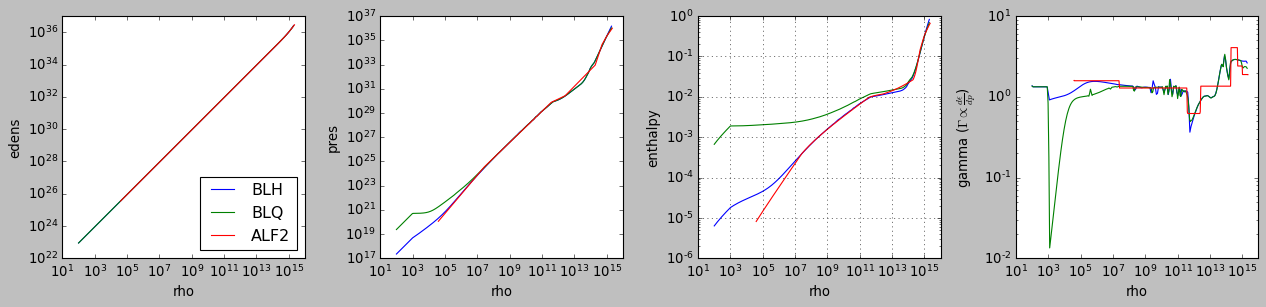

In [ ]:

fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2


"""
key='BLH'
blh=np.loadtxt('./eos_tables/BLH_new_14-Apr-2020.lorene',comments='#')
rho_arr, edens_arr, p_arr = (blh[:,1],blh[:,2],blh[:,3])

enth_arr=[]
enth_arr.append(2.5*np.log((edens_arr[0]+p_arr[0])/edens_arr[0]))

for i,(rho,edens,p) in enumerate(zip(rho_arr,edens_arr,p_arr)):
    if i > 0:
        c = np.log(p/p_arr[i-1])/np.log(edens/edens_arr[i-1])
        enth_arr.append(enth[i-1]+(c/(c-1))*np.log(edens_arr[i-1]/edens*(edens+p)/(edens_arr[i-1]+p_arr[i-1])))
        
print(enth_arr,len(enth_arr))
index=np.array([int(i) for i in range(len(rho_arr))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_arr/dens_conversion, edens_arr/edens_conversion, p_arr, gamma_new, enth_arr],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')
"""

keys=['BLH','BLQ','ALF2'] #,'ALF2_matlab']
files=['./eos_tables/BLH_new_14-Apr-2020.lorene','./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene','./eos_tables/ALF2_table.out',]
    
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

for key,file in zip(keys,files):
    eos=np.loadtxt(file,comments='#',skiprows=8)
    rho_arr, edens_arr, pres_arr = (eos[:,1],eos[:,2],eos[:,3])
    rho_arr = rho_arr*dens_conversion
    edens_arr = edens_arr*edens_conversion
    
    dp_dedens_arr=np.gradient(pres_arr,edens_arr) #https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    gamma_arr=((edens_arr+pres_arr)/pres_arr) * dp_dedens_arr 
    enth_arr=[]
    enth_arr.append(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
    print(2.5*np.log((edens_arr[0]+pres_arr[0])/edens_arr[0]))
    for i,(rho,edens,pres) in enumerate(zip(rho_arr,edens_arr,pres_arr)):
        if i > 0:
            c = np.log(pres/pres_arr[i-1])/np.log(edens/edens_arr[i-1])
            enth_arr.append(enth_arr[i-1]+(c/(c-1))*np.log(edens_arr[i-1]/edens*(edens+pres)/(edens_arr[i-1]+pres_arr[i-1])))
            #print(enth_arr[i-1])
    #print(enth_arr,len(enth_arr))

    #p_new=np.logspace(14,36,500)
    #key='BLQ'
    #rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs


    index=np.array([int(i) for i in range(len(rho_arr))])   #rho_arr/dens_conversion, edens_arr/edens_conversion  
    np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_arr, edens_arr, pres_arr, gamma_arr, enth_arr],header='\n#i rho edens pres gamma enthalpy',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

    #print(enth_arr)
    ax1.plot(rho_arr,edens_arr,label=key)
    #ax1.set_xlim([9.e11,1.e16]); 
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set(xlabel='rho',ylabel='edens')
    ax1.legend(loc=4)
    
    ax2.plot(rho_arr,pres_arr)
    ax2.set(xlabel='rho',ylabel='pres')
    #ax2.set_xlim([9.e11,1.e16]) 
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax3.plot(rho_arr,enth_arr)
    ax3.set(xlabel='rho',ylabel='enthalpy')
    ax3.grid(True)
    #ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
    ax3.set_xscale('log'); ax3.set_yscale('log')
    
    ax4.plot(rho_arr,gamma_arr,label=r'$\Gamma\propto\frac{d\epsilon}{dp}$')
    ax4.set_xscale('log'); ax4.set_yscale('log')
    ax4.set(xlabel='rho',ylabel=r'gamma')
    
    
    
    #splrep(edens,enth,k=3,s=0)
    
plt.tight_layout()
plt.show()


    
    

In [ ]:
eosfile='./eos_tables/BLH_data.out'
ds=np.loadtxt(eosfile,comments='#',skiprows=5)
print(eosfile, len(ds))
rho, edens, pres, gamma, enth = (ds[:,1],ds[:,2],ds[:,3],ds[:,4],ds[:,5])
print(gamma,len(gamma))
h_in=120
#rho_out   = splev(h_in,splrep(enth,rho,k=3,s=0)) 
edens_out = splev(h_in,splrep(enth,edens,k=3,s=0)) 
gamma_out = splev(h_in,splrep(enth,gamma,k=3,s=0))
pres_out  = splev(h_in,splrep(enth,pres,k=3,s=0))
print(edens_out, gamma_out, pres_out)

./eos_tables/BLH_data.out 199
[1.33216699 1.33216699 1.33216699 1.33216699 1.33216699 1.33216698
 1.33216698 1.33216698 1.33216698 1.33216698 1.33216698 1.33216698
 1.33216698 1.32178838 1.1079997  0.91635925 0.9276157  0.93778059
 0.94703038 0.95553663 0.96346875 0.97099307 0.9782737  0.98547363
 0.99275602 1.00028548 1.00822906 1.01675604 1.02603947 1.03625102
 1.04756635 1.06015606 1.07418151 1.08979487 1.10711658 1.12623572
 1.14720052 1.16999654 1.19454719 1.22069801 1.24820207 1.27673463
 1.30589506 1.33521738 1.36419446 1.39230482 1.41901581 1.44390852
 1.46662025 1.48684444 1.50439946 1.51919481 1.53126235 1.54070723
 1.54768579 1.55240047 1.55509103 1.55596492 1.55525055 1.55318275
 1.54994736 1.54569266 1.54061229 1.53482969 1.52845343 1.52161938
 1.51441862 1.50694513 1.49931102 1.49139858 1.48404273 1.4738808
 1.46619432 1.46050436 1.45290544 1.44553989 1.4383963  1.4269992
 1.41876803 1.41763514 1.41363561 1.4074329  1.40201463 1.39660709
 1.39153446 1.38660452 1.38210561 

## Original TOV equation --
* checking different integrator

In [2]:


class tov():

    def __init__(self, peos,int_pts,rad_low,rad_high,central_rho_arr,eos_file=None):
        self.physical_eos = peos
        self.eos_file = eos_file
        self.int_pts = int_pts
        self.rad_low = rad_low
        self.rad_high = rad_high
        self.rhocs = central_rho_arr

    def calc_tidal_deformability(self, C, Y,m):
        # """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and 
        # the Lindblom y-potential at the surface of a polytropic star"""

        # Eq.(C1,C2) of Lindblom & Indik 2014
        zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
        Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
        lambda_dimensional =   Lambda_dimensionless/const.CGS_G *(const.CGS_G*m*const.CGS_MSUN/const.CGS_C**2)**5
        return lambda_dimensional

    def tov(self, y,r):
        
        P, m, m_baryon, yp = y
        
        #if eos_file != None:
        eden = self.physical_eos.edens_inv( P )
        rho = self.physical_eos.rho( P )
        eos_gamma = self.physical_eos.gamma_inv(P)
        
        G=const.CGS_G; c=const.CGS_C 

        dPdr = -G*(eden + P/c**2)*(m + 4.0*np.pi*r**3*P/c**2)
        dPdr = dPdr/(r*(r - 2.0*G*m/c**2))
        dmdr = 4.0*np.pi*r**2*eden
        dm_baryondr = 4.0*np.pi*r**2*eden*(1-2*G*m/(r*c**2))**(-0.5)
        #G=cgs.G; c=cgs.c
        
        rho=eden*const.CGS_C**2
        dypdr= -yp**2/r -(r + (G/c**4)*4*np.pi*r**3*(P-rho))*yp/(r*(r-2*G*m/c**2)) + (G**2/c**4)*(4*(m+4*np.pi*r**3*P/c**2)**2)/(r*(r-2*G*m/c**2)**2) + 6/(r-2*const.CGS_G*m/const.CGS_C**2) - 4*np.pi*(r**2)*(5*rho+9*P+(rho+P)**2/(P*eos_gamma))*G/(c**4 * (r-2*G*m/c**2))

        return [dPdr, dmdr, dm_baryondr,dypdr]

    def tovsolve(self, rhoc):
        
        r = np.linspace(self.rad_low, self.rad_high, self.int_pts)
        #r = np.logspace(-4,6.3,N)
        P = self.physical_eos.pressure( rhoc )
        eden = self.physical_eos.edens_inv( P )
        rho = self.physical_eos.rho( P )
        
        m = 4./3.*np.pi*r[0]**3*eden
        m_baryon = 4./3.*np.pi*r[0]**3*eden*(1-2*const.CGS_G*m/(r[0]*const.CGS_C**2))**(-0.5)
        yp=2.
        psol = odeint(self.tov, [P, m, m_baryon, yp], r, rtol=1.0e-6, atol=1.0e-4)
        #print(self.rad_low,self.rad_high)
        #psol = solve_ivp(self.tov, [self.rad_low, self.rad_high] ,[P, m, m_baryon, yp], method='RK45',t_eval=r)
        #print m, m_baryon, rhoc
        return r, psol[:,0], psol[:,1], psol[:,2], psol[:,3]
        #return psol.t, psol.y[0], psol.y[1], psol.y[2], psol.y[3] 
        
    def find_surface(self,pmin, rhoc, rad_high):
        int_pts=2000
        rad_low=1.e-3
        r_arr = np.linspace(rad_low, rad_high,int_pts)
        #r = np.logspace(-4,6.3,N)

        #star = tovsolve(rhoc,r_arr)

        Pc,dummy = eos_from_dens(rhoc,eos_file)
        rhoc,eden_c,Gamma_c,cs_c = eos_from_pres(Pc,eos_file)
        #print(f'for pressure in: {Pc:1.2e}, density is {rhoc:1.2e}, edens: {eden_c:1.2e}, Gamma:{Gamma_c} and sound speed: {cs_c:1.2e}')
        rmin = r_arr[0]
        #print(f'rmin:{rmin:1.2e}')
        r3=rmin**3
        m = 4./3.*np.pi*r3*eden_c
        #print('g_00',np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2)))
        m_baryon = m/np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))
        yp=2.

        var_vec=[Pc, m, m_baryon, yp]
        #psol = solve_ivp(tov, [rad_low, rad_high] ,var_vec, method='RK45') #psol.y[0][-1]-pmin
        psol = odeint(self.tov, var_vec, r_arr, rtol=1.0e-6, atol=1.0e-4)
        return psol[:,0][-1]-pmin

    def mass_radius(self):
        
        pmin=1.e-12 #dyne/cm^2
        #N = 300
        mcurve = np.zeros(N)
        rcurve = np.zeros(N)
        mbcurve = np.zeros(N)
        ypcurve = np.zeros(N)
        rhocs = self.rhocs  #

        mass_max = 0.0
        j = 0
        for rhoc in rhocs:
            
            rstar = optimize.brentq(lambda rad_high: self.find_surface(pmin,rhoc,rad_high), 6.e5, 3.e6,rtol=1.e-1)
            print('rstar (km)',rstar/1.e5)
            
            rad, press, mass, mass_baryon, yp_lambda = self.tovsolve(rhoc)
            
            

            rad  /= 1.0e5 #cm to km
            mass /= const.CGS_MSUN
            mass_baryon /= const.CGS_MSUN
            #print self.peos
            #print rad
            #print "Central Density=%f, Gravitational Mass=%f, Baryonic Mass=%f, Radius=%f"%(rhoc,mass.max(),mass_baryon.max(),rad.max())

            mstar = mass[-1]
            rstar = rad[-1]
            ypstar = yp_lambda[-1]
            for i, p in enumerate(press):
                if p > 0.0:
                    mstar = mass[i]
                    rstar = rad[i]
                    mbaryonStar = mass_baryon[i]
                    ypstar = yp_lambda[i]
            mcurve[j] = mstar
            rcurve[j] = rstar
            mbcurve[j] = mbaryonStar
            
            C=(const.CGS_G/const.CGS_C**2)*(mstar*const.CGS_MSUN)/(rstar*1.e5)
            ypcurve[j] = ypstar
            ypcurve[j] = self.calc_tidal_deformability(C,ypstar,mstar) 
    


            j += 1
            if mass_max < mstar:
                mass_max = mstar
            else:
                break

        return mcurve[:j], rcurve[:j], rhocs[:j], mbcurve[:j], ypcurve[:j]


In [3]:
key='ALF2'
dense_eos = get_eos(key)
eos = glue_crust_and_core( SLyCrust, dense_eos )

rho_arr = np.logspace(12,15,100)
pres_arr = [eos.pressure(rho) for rho in rho_arr]
eden_arr = [eos.edens_inv(rho) for rho in rho_arr]
gamma_arr = [eos.gamma_inv(rho) for rho in rho_arr]


rhoc=1.e13
Pc=eos.pressure(rhoc)
P_in = np.logspace(24,np.log10(Pc),100)
#print(h_in)
eden = eos.edens_inv( P )
rho = eos.rho( P )

edens, eos_gamma, P, rho = ALF2.eos_from_h(h_in)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

ax1.plot(h_in,edens)
#ax1.set_xlim([9.e11,1.e16]); 
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set(xlabel='h_in',ylabel='edens')

ax2.plot(h_in,eos_gamma)
ax2.set(xlabel='h_in',ylabel='eos_gamma')
#ax2.set_xlim([9.e11,1.e16]) 
ax2.set_xscale('log'); ax2.set_yscale('log')

ax3.plot(h_in,P)
ax3.set(xlabel='h_in',ylabel='Pressure')
ax3.grid(True)
#ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
ax3.set_xscale('log'); ax3.set_yscale('log')

ax4.plot(h_in, rho)
ax4.set_xscale('log'); ax4.set_yscale('log')
ax4.set(xlabel='h_in',ylabel='rho')
    
#plt.loglog(edens,h_in)
#plt.show()

plt.tight_layout()
plt.show()

NameError: name 'P' is not defined

In [ ]:
key='ALF2'
dense_eos = get_eos(key)
eos = glue_crust_and_core( SLyCrust, dense_eos )





int_pts = 10000
rad_low = 1.e-3
rad_high = 3.e6
N = 100
rhoc_arr = np.logspace(np.log10(2.e14), np.log10(8.e15), N)
ALF2=tov(peos=eos,int_pts=int_pts,rad_low=rad_low,rad_high=rad_high,central_rho_arr=rhoc_arr)

masses,radii,rhocs,mbs,yps = ALF2.mass_radius()

print(masses)
plt.plot(radii,masses)
plt.axhline(y=masses[0])
plt.show()

ValueError: f(a) and f(b) must have different signs

[0.08565641 0.0859331  0.08682241 0.08859257 0.09150472 0.095804
 0.10170421 0.10937204 0.11891569 0.13040815 0.14394652 0.15966041
 0.17770529 0.19826413 0.22153912 0.24775038 0.27713184 0.30992932
 0.34639014 0.38676673 0.43130268 0.4802249  0.53374673 0.59202872
 0.65521656 0.72338196 0.79654362 0.8746238  0.95748541 1.01718106
 1.06720433 1.11633942 1.16458556 1.21193117 1.25835734 1.30383717
 1.3483383  1.39182468 1.43425655 1.47558887 1.51578239 1.55478993
 1.5925653  1.6290683  1.66425102 1.69807072 1.73048961 1.76147625
 1.79098317 1.81899087 1.84260803 1.86177994 1.87931756 1.89523473
 1.9095672  1.92235478 1.9336524  1.94350395 1.95195955 1.95907471
 1.9648997  1.96948451 1.97287557 1.97512753 1.97628689 1.97640109
 1.97551506]


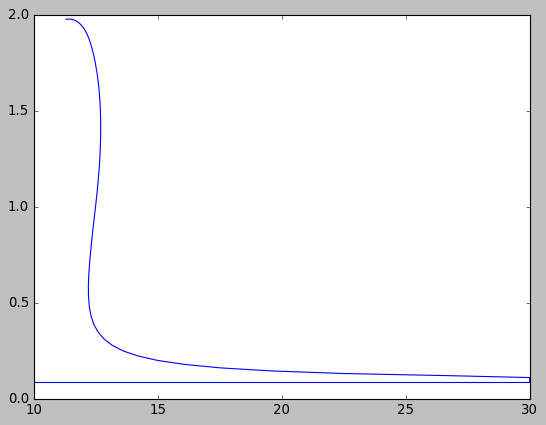

In [ ]:
print(masses)
plt.plot(radii,masses)
plt.axhline(y=masses[0])
plt.show()

0.001 3000000.0


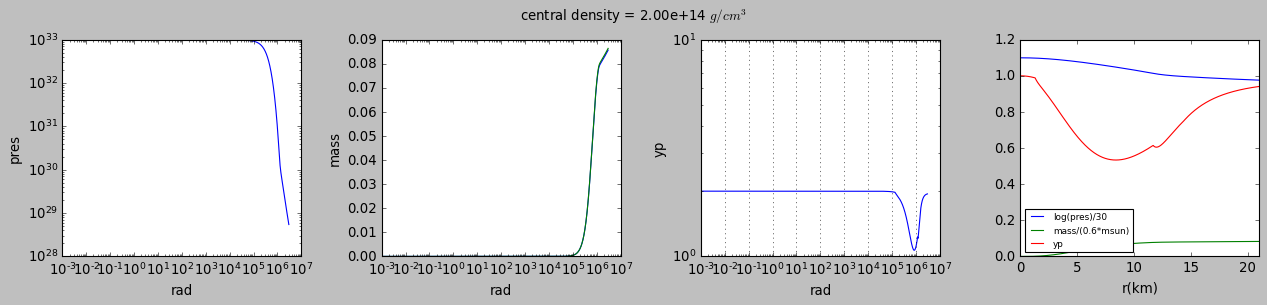

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


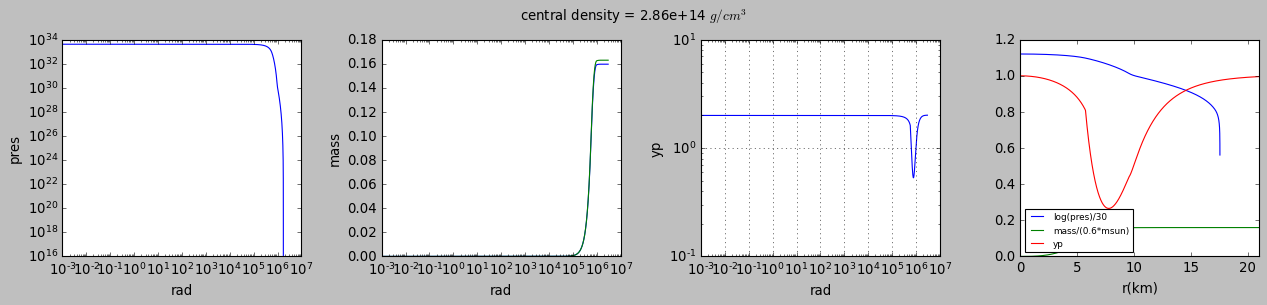

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


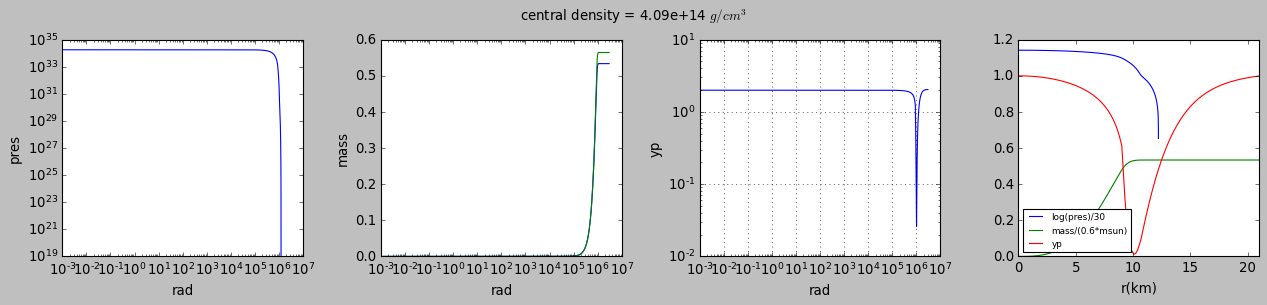

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


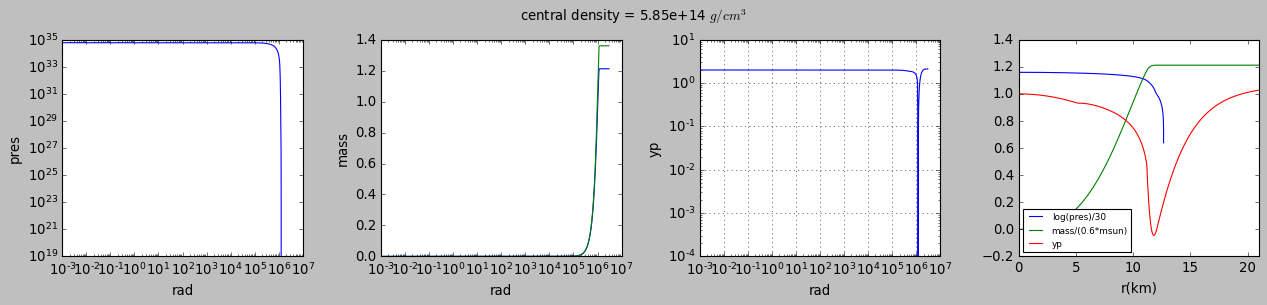

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


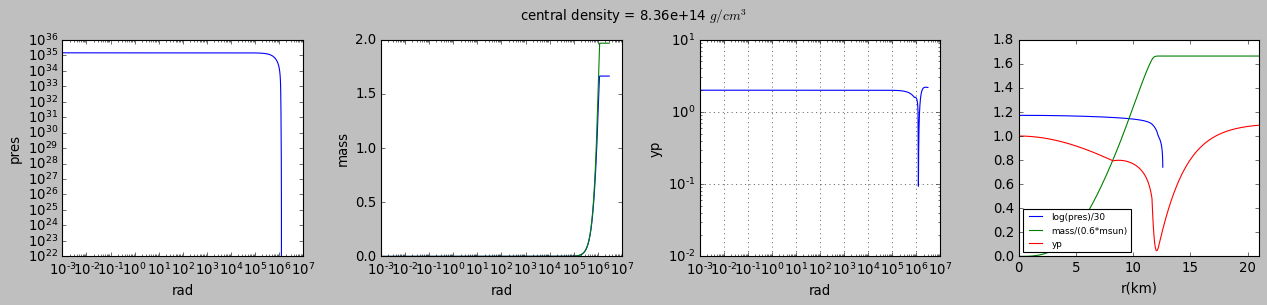

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


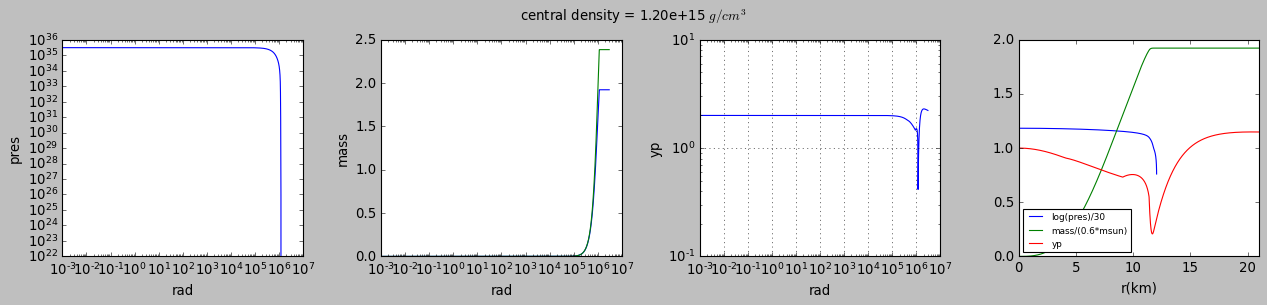

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


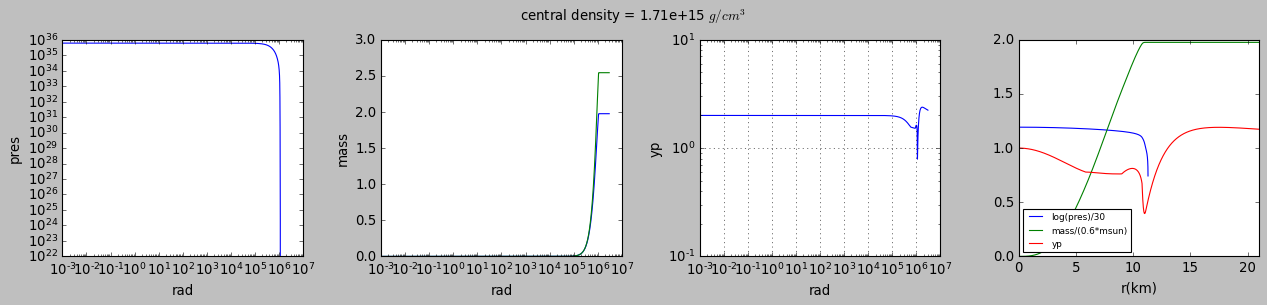

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


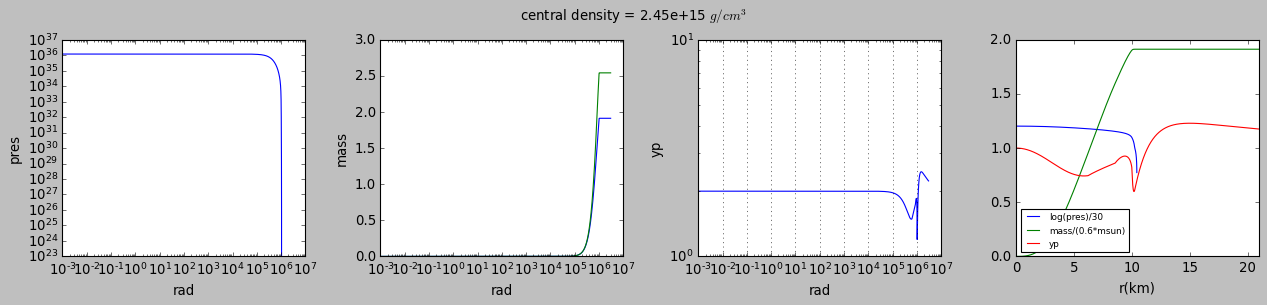

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


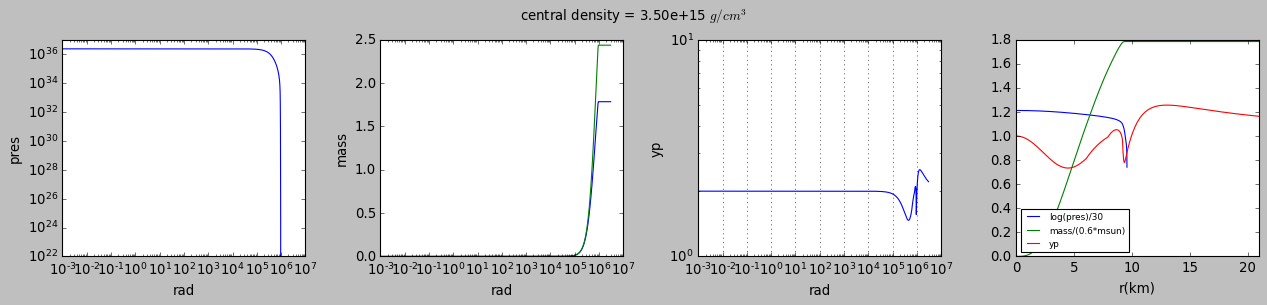

0.001 3000000.0


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


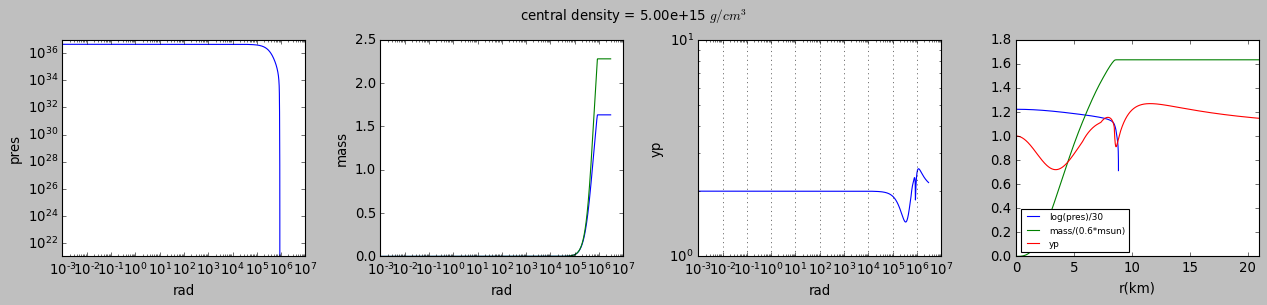

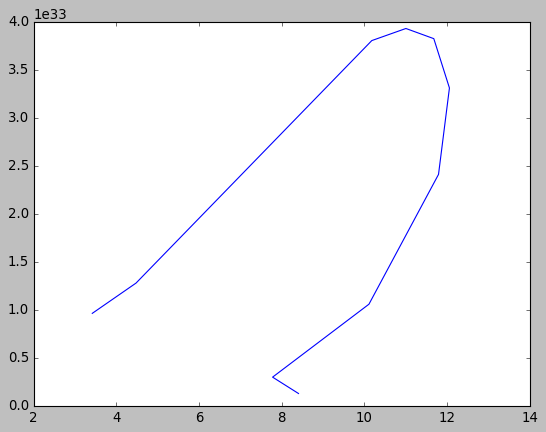

In [ ]:
key='ALF2'
dense_eos = get_eos(key)
eos = glue_crust_and_core( SLyCrust, dense_eos )





int_pts = 10000
rad_low = 1.e-3
rad_high = 3.e6
N = 10
rhoc_arr = np.logspace(np.log10(2.e14), np.log10(5.e15), N)
ALF2=tov(peos=eos,int_pts=int_pts,rad_low=rad_low,rad_high=rad_high,central_rho_arr=rhoc_arr)

rstar=[]
mstar=[]
lamstar=[]
for rhoc in rhoc_arr:
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
    fig.suptitle(f'central density = {rhoc:1.2e} $g/cm^3$')
    rad, press, mass, mass_baryon, yp_lambda = ALF2.tovsolve(rhoc)
    
    ax1.plot(rad,press)
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set(xlabel='rad',ylabel='pres')
    
    ax2.plot(rad,mass/const.CGS_MSUN)
    ax2.plot(rad,mass_baryon/const.CGS_MSUN)
    ax2.set(xlabel='rad',ylabel='mass')
    #ax2.set_xlim([9.e11,1.e16]) 
    ax2.set_xscale('log')#; ax2.set_yscale('log')
    
    ax3.plot(rad,yp_lambda)
    ax3.set(xlabel='rad',ylabel='yp')
    ax3.grid(True)
    #ax3.set_xlim([9.e11,1.e16]);ax3.set_ylim([0,1])
    ax3.set_xscale('log'); ax3.set_yscale('log')
    
    ax4.plot(rad/1.e5,np.log10(press)/30,label='log(pres)/30')
    ax4.plot(rad/1.e5,mass/const.CGS_MSUN,label='mass/(0.6*msun)')
    ax4.plot(rad/1.e5,yp_lambda/2,label='yp')
    #ax4.set_xscale('log'); ax4.set_yscale('log')
    ax4.set(xlabel='r(km)') #,ylabel='P')
    ax4.set_xlim([0,21])
    ax4.legend(loc=3,fontsize=8)
    plt.tight_layout()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    idx=np.argmin(yp_lambda)  #.index(min(yp_lambda))
    
    rstar.append(rad[idx])
    mstar.append(mass[idx])
    lamstar.append(yp_lambda[idx])

rstar=np.array(rstar); mstar=np.array(mstar)
plt.plot(rstar/1.e5,mstar)
plt.show()

## TOV solver testing to find the ns surface and using lorene data

In [ ]:
#import time
from tovlib import *
from scipy.integrate import solve_ivp
#eos_file = './eos_tables/BLH_new_14-Apr-2020.lorene'
#eos_file = './eos_tables/SLy.lorene'


is_sorted = lambda x: (np.diff(x)>=0).all()

def eos_from_pres(pres_in,eos_file='./eos_tables/BLH_new_14-Apr-2020.lorene'):
    
    #if(pres_in.any()<0):
    #    print('pressure input is negative; stop integration and go to previous radial point')
    lg_pres_in = np.log10(pres_in)
    
    fm=1.e-13 #1femotometer in cm
    dens_conversion=const.CGS_AMU/(fm**3)
    edens_conversion=const.CGS_C**2
    
    ds=np.loadtxt(eos_file,comments='#',skiprows=9)
    #rho=ds[:,1]; edens=ds[:,2]; pres=ds[:,3]
    #print('all density > 0? ',all(i >= 0 for i in rho),'; all edens > 0? ',all(i >= 0 for i in edens),'; all pres > 0? ',all(i >= 0 for i in pres))
    #print('is_sorted(rho)? ',is_sorted(rho),'; is_sorted(edens)? ',is_sorted(edens),'; is_sorted(pres) ',is_sorted(pres))

    lg_rho, lg_edens, lg_pres = (np.log10(ds[:,1]),np.log10(ds[:,2]),np.log10(ds[:,3]))

    ind=lg_rho.argsort()                 # sorting mass and other array; necessary for interpolation routine
    sort_ind = ind[::1]
    lg_rho=lg_rho[sort_ind]
    lg_edens=lg_edens[sort_ind]
    lg_pres=lg_pres[sort_ind]
    
    
    #print(is_sorted(rho))
    #dp_dedens_arr=diff(pres)/diff(edens)/edens_conversion
    #dp_dedens_arr = np.insert(dp_dedens_arr, 0, dp_dedens_arr[0], axis=0)

    dlg_p_dlg_edens_arr=np.gradient(lg_pres,lg_edens) #https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    gamma_arr = dlg_p_dlg_edens_arr
    Gamma_arr=((np.power(10,lg_edens)*edens_conversion+np.power(10,lg_pres))/(np.power(10,lg_edens)*edens_conversion)) * gamma_arr 
    
    rho_out=10**(splev(lg_pres_in,splrep(lg_pres,lg_rho,k=3,s=0)) )
    edens_out=10**(splev(lg_pres_in,splrep(lg_pres,lg_edens,k=3,s=0))) 
    Gamma_out=splev(lg_pres_in,splrep(lg_pres,gamma_arr,k=3,s=0))
    cs_out=np.sqrt((pres_in/edens_out)*(splev(lg_pres_in,splrep(lg_pres,gamma_arr,k=3,s=0))))  #sound speed: sqrt(dpres/dedens) = 
    #gamma_out=5./3.
    return rho_out*dens_conversion, edens_out, Gamma_out, cs_out


def eos_from_dens(rho_in,eos_file='./eos_tables/BLH_new_14-Apr-2020.lorene'):
    
    lg_rho_in = np.log10(rho_in)
    #print(lg_rho_in)
    fm=1.e-13 #1femotometer in cm
    dens_conversion=const.CGS_AMU/(fm**3)
    edens_conversion=const.CGS_C**2
    
    ds=np.loadtxt(eos_file,comments='#',skiprows=9)
    lg_rho, lg_edens, lg_pres = (np.log10(ds[:,1]*dens_conversion),np.log10(ds[:,2]),np.log10(ds[:,3]))
    #print(lg_rho)
    pres_out=10**(splev(lg_rho_in,splrep(lg_rho,lg_pres,k=3,s=0)) )
    edens_out=10**(splev(lg_rho_in,splrep(lg_rho,lg_edens,k=3,s=0))) 
    
    return pres_out, edens_out

In [ ]:
print(f'{dens_conversion:1.2e}')
pres_in=1.e37 
eos_file='./eos_tables/eosDD2.lorene'
rho_out,edens_out,Gamma_out,cs_out = eos_from_pres(pres_in,eos_file)
print(f'for pressure in: {pres_in:1.2e}, density is {rho_out:1.2e} and sound speed: {cs_out:1.2e}')

pres_out, edens_out = eos_from_dens(rho_out,eos_file)
print(f'when you put the rho_out to back in you should get back the pressure: {pres_out:1.2e}')

1.66e+15
for pressure in: 1.00e+37, density is 4.58e+15 and sound speed: 2.83e+10
when you put the rho_out to back in you should get back the pressure: 1.00e+37


############ eosDD2 ###########
is_sorted(edens_new) False is_sorted(rho_new) False
rho limits: min:9.802e+01, max=1.464e+16


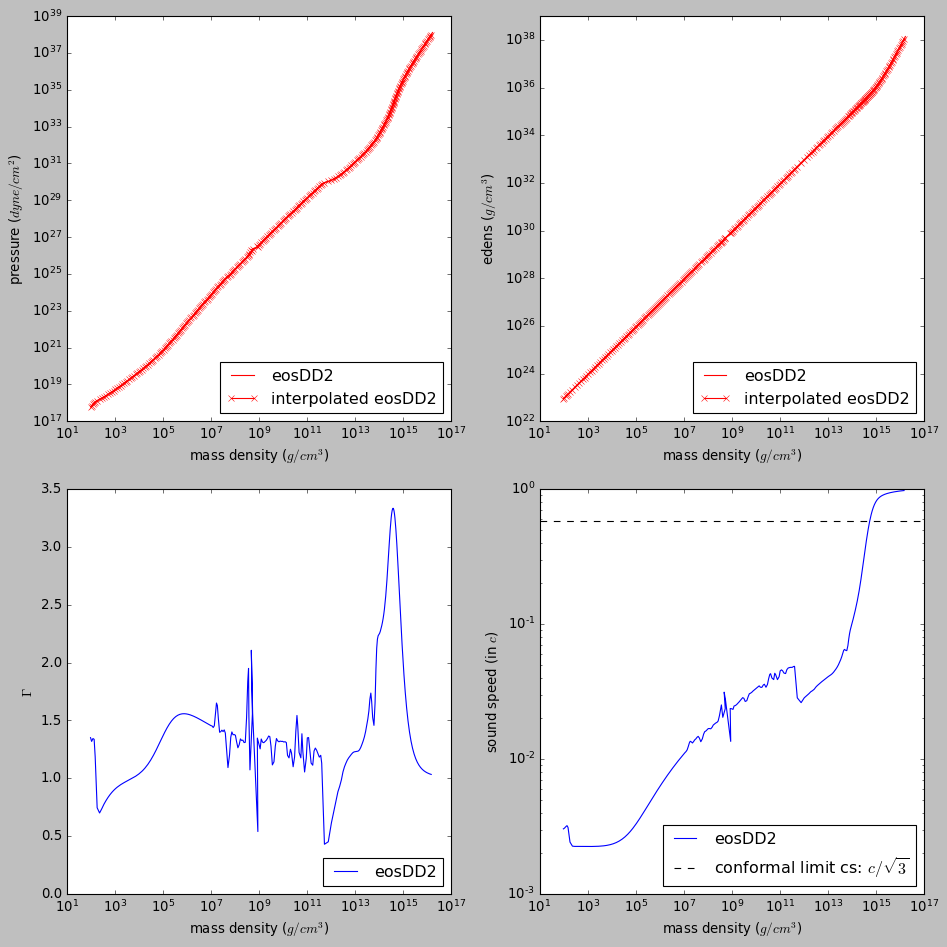

"key='BLQ'\nrho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs\nindex=np.array([int(i) for i in range(len(p_new))])\nnp.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')\n\nkey='BLH'\nrho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLH_new_14-Apr-2020.lorene') #returns in cgs\nindex=np.array([int(i) for i in range(len(p_new))])\nnp.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')\n"

In [ ]:



###################################################################################3

fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

eos_dir = './eos_tables/'
eos_list=['eosDD2'] #['eosSLy','eosDD2','eos0']  #['eosSLy'] #,'eosDD2']
c_list=['r','b','c','k','g']
p_new=np.logspace(np.log10(6.e17),np.log10(1.e38),300)
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2,figsize=(12,12))

for eoskey,color in zip(eos_list,c_list):
    print(f'############ {eoskey} ###########')
    eos_file = eos_dir+eoskey+'.lorene'
    eos_tabdata = np.loadtxt(eos_file,comments='#',skiprows=9)
    rho, edens, pres = (eos_tabdata[:,1],eos_tabdata[:,2],eos_tabdata[:,3])
    #print(eoskey,'\n####\n',rho,'\n#####\n',edens)
    #for p_in in p_new:
    rho_new, edens_new, gamma_new, cs_new = eos_from_pres(p_new,eos_file)
    
    print('is_sorted(edens_new)',is_sorted(edens_new),'is_sorted(rho_new)',is_sorted(rho_new))
    print(f'rho limits: min:{min(rho_new):1.3e}, max={max(rho_new):1.3e}')
    ax1.plot(rho*dens_conversion,pres,c=color,label=eoskey)
    ax1.plot(rho_new,p_new,c=color,marker='x',label='interpolated '+eoskey)
    #ax1.set_xlim([1.e14,1.e16])
    #ax1.set_ylim([1.e32,1.e36])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'pressure ($dyne/cm^2$)')
    ax1.legend(loc=4)

    ax2.plot(rho*dens_conversion,edens*edens_conversion,c=color,label=eoskey)
    ax2.plot(rho_new,edens_new*edens_conversion,c=color,marker='x',label='interpolated '+eoskey)
    #ax2.set_xlim([1.e14,1.e16])
    #ax2.set_ylim([1.e34,1.e37])
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'edens ($g/cm^{3}$)')
    ax2.legend(loc=4)

    ax3.plot(rho_new,gamma_new,label=eoskey)
    ax3.set_xscale('log')
    ax3.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'$\Gamma$')
    ax3.legend(loc=4)
    
    ax4.plot(rho_new,cs_new/const.CGS_C,label=eoskey)
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'sound speed (in $c$)')
    
    
ax4.axhline(1/np.sqrt(3),ls='--',c='k',label='conformal limit cs: $c/\sqrt{3}$')
ax4.legend(loc=4)
plt.tight_layout()
#plt.savefig('eos_plots_phase.png',dpi=150)

plt.show()

## saving eos data in a file in a specific format -- 
"""key='BLQ'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

key='BLH'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLH_new_14-Apr-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')
"""


for pressure in: 1.00e+34, density is 3.41e+14 and sound speed: 8.93e+09
when you put the rho_out to back in you should get back the pressure: 1.00e+34


In [ ]:
print(const.CGS_K*16500)

2.27807052e-12


In [ ]:

## Root finding by reducing the radial interval and by using scipy.rootfind functions. 
## Works and matches with the MATLAB code.. although there are problems of (1) Speed and (2) accuracy 
from scipy import optimize
eos_file = './eos_tables/eos4.lorene'
#eos_file = './eos_tables/eos0.lorene'  #eosBHB


def calc_tidal_deformability(C, Y):
    # """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and 
    # the Lindblom y-potential at the surface of a polytropic star"""
    # Eq.(C1,C2) of Lindblom & Indik 2014
    zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
    Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
    #lambda_dimensional =   Lambda_dimensionless/const.CGS_G *(const.CGS_G*m*const.CGS_MSUN/const.CGS_C**2)**5
    return Lambda_dimensionless

def tov(r,y):

    [P, m, m_baryon, yp] = y
    #if(P<0):
    #    sys.exit()
    #if eos_file != None:
    #P,dummy = eos_from_dens(rhoc,eos_file)
    rho,eden,eos_gamma, cs = eos_from_pres(P,eos_file)

    G=const.CGS_G; c=const.CGS_C 

    dPdr = -G*(eden + P/c**2)*(m + 4.0*np.pi*r**3*P/c**2)
    dPdr = dPdr/(r*(r - 2.0*G*m/c**2))
    dmdr = 4.0*np.pi*r**2*eden
    dm_baryondr = dmdr/np.sqrt(1-2*G*m/(r*c**2))
    #G=cgs.G; c=cgs.c

    rho=eden*const.CGS_C**2
    dypdr= -yp**2/r -(r + (G/c**4)*4*np.pi*r**3*(P-rho))*yp/(r*(r-2*G*m/c**2)) + (G**2/c**4)*(4*(m+4*np.pi*r**3*P/c**2)**2)/(r*(r-2*G*m/c**2)**2) + 6/(r-2*const.CGS_G*m/const.CGS_C**2) - 4*np.pi*(r**2)*(5*rho+9*P+(rho+P)**2/(P*eos_gamma))*G/(c**4 * (r-2*G*m/c**2))

    return [dPdr, dmdr, dm_baryondr,dypdr]

def tovsolve(rhoc,r_arr):
    P,dummy = eos_from_dens(rhoc,eos_file)
    rho,eden,Gamma,cs = eos_from_pres(P,eos_file)
    
    rad_low = r_arr[0]; rad_high = r_arr[-1]
    print(rad_low,rad_high)
    
    rmin = r_arr[0]
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden
    m_baryon = 4./3.*np.pi*r3*eden*(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))**(-0.5)
    yp=2.
    #psol = odeint(tov, [P, m, m_baryon, yp], r_arr, rtol=1.0e-6, atol=1.0e-4,tfirst=True)

    psol = solve_ivp(tov, [rad_low, rad_high] ,[P, m, m_baryon, yp], method='RK45',t_eval=r_arr)
    #print m, m_baryon, rhoc
    #return r_arr, psol[:,0], psol[:,1], psol[:,2], psol[:,3]
    return psol.t, psol.y[0], psol.y[1], psol.y[2], psol.y[3] 


def find_surface(pmin, rhoc, rad_high):
    int_pts=10000
    rad_low=1.e-3
    r_arr = np.linspace(rad_low, rad_high,int_pts)
    #r = np.logspace(-4,6.3,N)

    #star = tovsolve(rhoc,r_arr)

    Pc,dummy = eos_from_dens(rhoc,eos_file)
    rhoc,eden_c,Gamma_c,cs_c = eos_from_pres(Pc,eos_file)
    #print(f'for pressure in: {Pc:1.2e}, density is {rhoc:1.2e}, edens: {eden_c:1.2e}, Gamma:{Gamma_c} and sound speed: {cs_c:1.2e}')
    rmin = r_arr[0]
    #print(f'rmin:{rmin:1.2e}')
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden_c
    #print('g_00',np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2)))
    m_baryon = m/np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))
    yp=2.
    
    var_vec=[Pc, m, m_baryon, yp]
    
    #psol = odeint(tov, var_vec, r_arr, rtol=1.0e-6, atol=1.0e-4,tfirst=True)
    #end_pres = psol[:,0][-1]
    #return end_pres-pmin

    psol = solve_ivp(tov, [rad_low, rad_high] ,var_vec, method='RK45')
    return psol.y[0][-1]-pmin
    ############################

    
    
    
###
time1=time.time()

#######################################################3
pmin=1.e-12
len_seq=5
rhoc_arr=np.logspace(np.log10(7.e14),np.log10(3.e15),len_seq)

tov_data=[]
for rhoc in rhoc_arr:
    #rhoc=4.e14 #cgs
    rstar = optimize.brentq(lambda rad_high: find_surface(pmin,rhoc,rad_high), 6.e5, 3.e6,rtol=1.e-4)
    #rstar = optimize.bisect(lambda rad_high: find_surface(pmin,rhoc,rad_high), 6.e5, 3.e6,rtol=1.e-5)
    
    #print(rstar/1.e5)

    time4= time.time()
    print('time elapsed in root finding:',time4-time1)

    rad_low = 1.e-3; rad_high = rstar
    int_pts=2000
    r_arr = np.linspace(rad_low, rad_high,int_pts)
    #r = np.logspace(-4,6.3,N)

    #star = tovsolve(rhoc,r_arr)

    Pc,dummy = eos_from_dens(rhoc,eos_file)
    rhoc,eden_c,Gamma_c,cs_c = eos_from_pres(Pc,eos_file)
    print(f'for pressure in: {Pc:1.2e}, density is {rhoc:1.2e}, edens: {eden_c:1.2e}, Gamma:{Gamma_c} and sound speed: {cs_c:1.2e}')
    rmin = r_arr[0]
    #print(f'rmin:{rmin:1.2e}')
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden_c
    #print('g_00',np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2)))
    m_baryon = m/np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))
    yp=2.
    psol = solve_ivp(tov, [rad_low, rad_high] ,[Pc, m, m_baryon, yp], method='RK45') #,t_eval=r_arr)
    [P, m, m_baryon, yp] = [psol.y[0][-1], psol.y[1][-1], psol.y[2][-1], psol.y[3][-1]]

    print(f'FINAL: rstar: {rstar/1.e5:1.2f}, grav. mass: {m/const.CGS_MSUN:1.2f}, bary. mass: {m_baryon/const.CGS_MSUN:1.2f}, yp: {yp}')
##
time2 = time.time()
print('time elapsed:',time2-time4)

"""
#######################################################
time2 = time.time()
#rhoc=3.e14 # cgs   

def get_tovStar(rhoc):
    rad_low=1.e-3
    rad_high=3.e6 
    int_pts=60
    r_arr = np.linspace(rad_low, rad_high,int_pts)
    
    Pc,dummy = eos_from_dens(rhoc,eos_file)
    rhoc,eden_c,Gamma_c,cs_c = eos_from_pres(Pc,eos_file)
    print(f'for central pressure: {Pc:1.2e}, density ={rhoc:1.2e}, edens = {eden_c:1.2e}, Gamma = {Gamma_c} and sound speed = {cs_c:1.2e}')
    rmin = r_arr[0]
    #print(f'rmin:{rmin:1.2e}')
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden_c
    #print('g_00',np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2)))
    m_baryon = m/np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))
    yp=2.
    y_new=[Pc, m, m_baryon, yp]
    pmin=1.e-12 #Pc*1.e-11
    print(f'minimum pressure to reach is = {pmin:1.2e}')

    eps_rad=1000 #cm
    dr=r_arr[1]-r_arr[0]
    
    eps_pres = 1.e-12; eps_mass = 1.e20; eps_yp = 1.e-6 
    for i,r in enumerate(r_arr):
        y_old = y_new
        tst_solvivp = time.time()
        psol = solve_ivp(tov, [r, r+dr] ,y_old, method='RK45',atol=[eps_pres,eps_mass,eps_mass,eps_yp],rtol=1.e-3)
        ten_solvivp = time.time()
        print(f'time per solve_ivp:{ten_solvivp-tst_solvivp}')
        [P, m, m_baryon, yp] = [psol.y[0][-1], psol.y[1][-1], psol.y[2][-1], psol.y[3][-1]]
        y_new = [P, m, m_baryon, yp]
        #print(f'NEW: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')

        if(P<pmin):
            n=int(dr/eps_rad)
            #print(r,dr,n)
            rad_arr = np.linspace(r,r+dr,n)

            ddr = rad_arr[1]-rad_arr[0]
            y_new2 = y_old
            for r in rad_arr:
                y_old = y_new2
                tst_solvivp = time.time()
                psol = solve_ivp(tov, [r, r+ddr] ,y_old, method='RK45',atol=[eps_pres,eps_mass,eps_mass,eps_yp],rtol=1.e-3)
                ten_solvivp = time.time()
                print(f'time per solve_ivp (finer grid):{ten_solvivp-tst_solvivp}')
                [P, m, m_baryon, yp] = [psol.y[0][-1], psol.y[1][-1], psol.y[2][-1], psol.y[3][-1]]
                y_new2 = [P, m, m_baryon, yp]
                if(P<pmin):       
                    [P, m, m_baryon, yp] = y_old
                    #print(f'radius: {r/1.e5} km, mass: {m/const.CGS_MSUN} solar mass')
                    print(f'Final: pressure: {P:1.2e}, rhoc:{rhoc:1.2e} radius: {r/1.e5} km, grav. mass: {m/const.CGS_MSUN:1.2f}, bary. mass: {m_baryon/const.CGS_MSUN:1.2f}, yp: {yp}')
                    break
            
            break
            
        #else:
            #print(f'did not reach pmin={pmin:1.2e} for eos={eos_file}')
    C=(G/c**2)*m/r
    lambda_dimensionless = calc_tidal_deformability(C,yp)
    return C, m_baryon/const.CGS_MSUN, m/const.CGS_MSUN, r/1.e5, lambda_dimensionless


len_seq=5
rhoc_arr=np.logspace(np.log10(6.e14),np.log10(3.e15),len_seq)

tov_data=[]
for rhoc in rhoc_arr:
    C,mb,mg,r,lam = get_tovStar(rhoc) 
    tov_data.append([C,mb,mg,r,lam])


print(tov_data)



time3 = time.time()
print('time elapsed in loops:',time3-time2)
"""



################################################
"""for i,r in enumerate(r_arr):
    #print(f'iteration:{i}, radial coordinate: {r_arr[i]}')

    y_old = y_new
    #[P, m, m_baryon, yp] = y_old
    #print(f'OLD: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')
    dr=r_arr[i+1]-r_arr[i]
    #print(f'dr: {dr:1.2e}')
    #print(tov(y,r))
    [dPdr, dmdr, dm_baryondr,dypdr] = tov(r,y_old)
    #print(f'dPdr:{dPdr:1.2e},dmdr:{dmdr:1.2e},dm_baryondr:{dm_baryondr:1.2e},dypdr:{dypdr:1.2e}')
    #print(dr*np.array([dPdr, dmdr, dm_baryondr,dypdr]))
    y_new=y_old+dr*np.array([dPdr, dmdr, dm_baryondr,dypdr])
    [P, m, m_baryon, yp] = y_new
    #print(f'NEW: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')

    pmin=Pc*1.e-11
    if(P<pmin):
        print(f'radius: {r/1.e5} km, mass: {m/const.CGS_MSUN} solar mass')
        sys.exit()"""


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


time elapsed in root finding: 275.82339906692505
for pressure in: 8.29e+34, density is 7.00e+14, edens: 7.51e+14, Gamma:2.6761947846358773 and sound speed: 1.72e+10
FINAL: rstar: 12.57, grav. mass: 1.30, bary. mass: 1.47, yp: 0.5292894116656919
time elapsed in root finding: 646.7676446437836
for pressure in: 2.46e+35, density is 1.01e+15, edens: 1.15e+15, Gamma:2.379121655484738 and sound speed: 2.26e+10
FINAL: rstar: 12.14, grav. mass: 1.86, bary. mass: 2.28, yp: 0.6311241063268154
time elapsed in root finding: 1147.3634808063507
for pressure in: 6.95e+35, density is 1.45e+15, edens: 1.86e+15, Gamma:1.939625258862031 and sound speed: 2.69e+10
FINAL: rstar: 11.28, grav. mass: 2.17, bary. mass: 2.87, yp: 1.030632557480974
time elapsed in root finding: 1643.4306349754333
for pressure in: 1.83e+36, density is 2.09e+15, edens: 3.24e+15, Gamma:1.6270256560704335 and sound speed: 3.03e+10
FINAL: rstar: 10.23, grav. mass: 2.18, bary. mass: 3.06, yp: 1.6104596610286652
time elapsed in root fin

"for i,r in enumerate(r_arr):\n    #print(f'iteration:{i}, radial coordinate: {r_arr[i]}')\n\n    y_old = y_new\n    #[P, m, m_baryon, yp] = y_old\n    #print(f'OLD: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')\n    dr=r_arr[i+1]-r_arr[i]\n    #print(f'dr: {dr:1.2e}')\n    #print(tov(y,r))\n    [dPdr, dmdr, dm_baryondr,dypdr] = tov(r,y_old)\n    #print(f'dPdr:{dPdr:1.2e},dmdr:{dmdr:1.2e},dm_baryondr:{dm_baryondr:1.2e},dypdr:{dypdr:1.2e}')\n    #print(dr*np.array([dPdr, dmdr, dm_baryondr,dypdr]))\n    y_new=y_old+dr*np.array([dPdr, dmdr, dm_baryondr,dypdr])\n    [P, m, m_baryon, yp] = y_new\n    #print(f'NEW: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')\n\n    pmin=Pc*1.e-11\n    if(P<pmin):\n        print(f'radius: {r/1.e5} km, mass: {m/const.CGS_MSUN} solar mass')\n        sys.exit()"

[15.40512821 12.34871795 12.12307693 10.82051283  9.1897436 ] 
 [0.22926188 0.80137714 1.78191345 2.20569905 2.0235669 ]


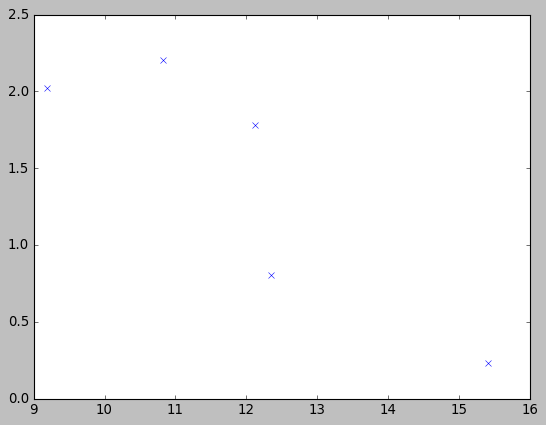

In [ ]:
tov_data=np.array(tov_data)
print(tov_data[:,3],'\n',tov_data[:,2])
plt.plot(tov_data[:,3],tov_data[:,2],'x')
rstar=tov_data[:,3]; mstar=tov_data[:,2]; lamstar=tov_data[:,4]; comstar=tov_data[:,0]
plt.show()

TypeError: list indices must be integers or slices, not tuple

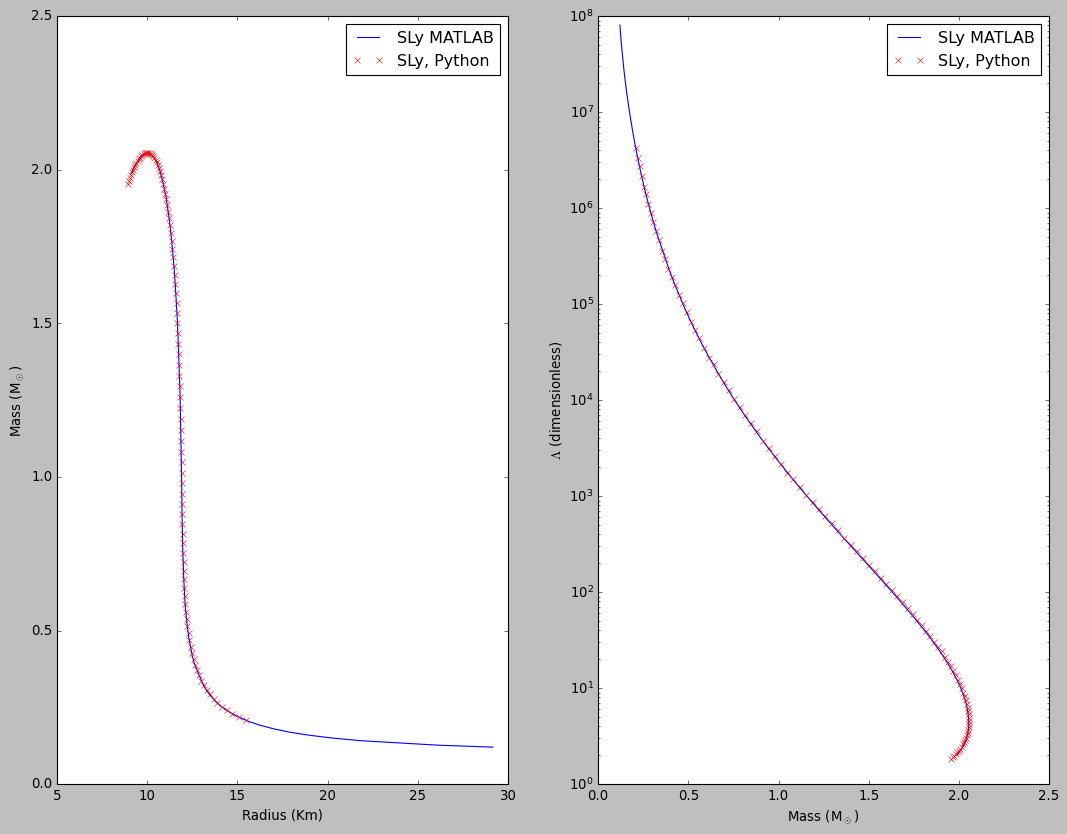

In [ ]:
file='../bns_prompt_collapse/git_bnspromptcollapse/scripts/eos_data/TOVSeq/TOVSeq_eosSLy.dat'
#GRMHDResearch/bns_prompt_collapse/git_bnspromptcollapse/scripts/eos_data/TOVSeq
eoskey='SLy'
fig,((ax1,ax2))=plt.subplots(nrows=1,ncols=2,figsize=(16,12))
ds=np.loadtxt(file,skiprows=1,delimiter=',')
mass = ds[:,2] #in solar mass
rad = const.AGEO_LENGTH_IN_CM/1.e5*ds[:,3] #in km 
k2 = ds[:,5] # K2 
C = ds[:,0] #compactness GM/(Rc^2)
lam_dimensionless = (2./3.) * ds[:,5] / (C**5.)
ax1.plot(rad,mass,label=eoskey+' MATLAB')
ax1.plot(rstar,mstar,'rx',label='SLy, Python')
ax1.set(xlabel='Radius (Km)',ylabel='Mass (M$_\odot$)')
ax1.legend()

#ax2.plot(ds[:,2],ds[:,5],label=eoskey)
ax2.semilogy(ds[:,2],lam_dimensionless,label=eoskey+' MATLAB')
ax2.plot(mstar,lamstar,'rx',label='SLy, Python')

ax2.set(ylabel='$\Lambda$ (dimensionless)',xlabel='Mass (M$_\odot$)')
ax2.legend()
    
#plt.legend()
plt.savefig('m_r_lam.png',dpi=200)
plt.show()

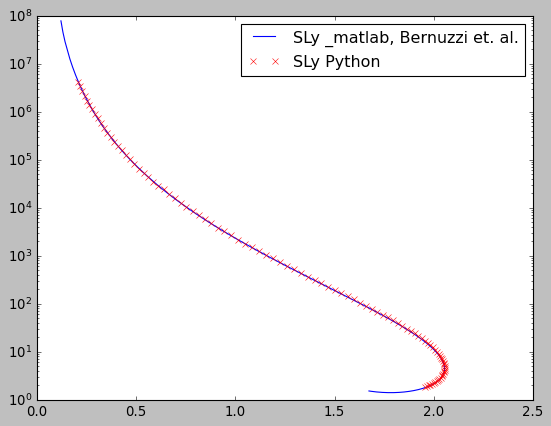

In [ ]:
#print(rstar/1.e5)
#print(mstar/const.CGS_MSUN)
#lamstar=np.array(lamstar)

file='./matlab_Sebastiano/tov/Sequences/Complete/SLy_sequence.txt'
ds_matlab=np.loadtxt(file,skiprows=1)
#plt.plot(ds_matlab[:,3]*const.AGEO_LENGTH_IN_M/1.e3,ds_matlab[:,1],label='SLy, matlab')
#plt.plot(rstar,mstar,label='yp_min values, ALF2')
plt.semilogy(ds_matlab[:,1],ds_matlab[:,6],label='SLy _matlab, Bernuzzi et. al.')
plt.semilogy(mstar,lamstar,'rx',label='SLy Python')
#plt.xlim([4,16])
plt.legend()
plt.show()

#plt.plot(mstar/const.CGS_MSUN,lamstar)
#plt.show()